In [64]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
sns.set(style='whitegrid')


In [40]:

DATA_PATH = '/content/drive/MyDrive/NEW_DATASET.csv'

df = pd.read_csv(DATA_PATH)
print('Loaded dataset:', DATA_PATH)
print('Rows, cols:', df.shape)
display(df.head())


candidate_targets = [c for c in df.columns if 'churn' in c.lower() or 'target' in c.lower() or 'label' in c.lower()]
if len(candidate_targets) >= 1:
    TARGET = candidate_targets[0]
    print(f"Auto-detected target column: '{TARGET}'")
else:
    TARGET = None
    print("No obvious target column found (didn't find 'churn', 'target', or 'label').")
    print("If you have a target column, set TARGET = 'YourTargetColumn' and re-run this cell.")

Loaded dataset: /content/drive/MyDrive/NEW_DATASET.csv
Rows, cols: (7043, 20)


,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureGroup,ChargesRatio,AvgMonthlyCost,ServicesCount
0,0,1,0,1,0.0,0,0.0,1.0,0.0,0.0,0,1,2,29.85,29.85,0,1,0.967585,14.925000,1.0
1,0,0,0,34,0.0,0,1.0,0.0,1.0,0.0,1,0,3,56.95,1889.50,0,3,0.030124,53.985714,2.0
2,0,0,0,2,0.0,0,1.0,1.0,0.0,0.0,0,1,3,53.85,108.15,1,1,0.493358,36.050000,2.0
3,0,0,0,45,0.0,0,1.0,0.0,1.0,1.0,1,0,0,42.30,1840.75,0,3,0.022967,40.016304,3.0
4,0,0,0,2,0.0,1,0.0,0.0,0.0,0.0,0,1,2,70.70,151.65,1,1,0.463151,50.550000,0.0


Auto-detected target column: 'Churn'


In [41]:
# Cell 3: data types, counts, missing values summary
print("DataFrame info:")
display(df.info())

print("\nMissing values (columns with any missing):")
missing = df.isnull().sum().sort_values(ascending=False)
display(missing[missing > 0])


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     7043 non-null   int64  
 1   Partner           7043 non-null   int64  
 2   Dependents        7043 non-null   int64  
 3   tenure            7043 non-null   int64  
 4   MultipleLines     7043 non-null   float64
 5   InternetService   7043 non-null   int64  
 6   OnlineSecurity    7043 non-null   float64
 7   OnlineBackup      7043 non-null   float64
 8   DeviceProtection  7043 non-null   float64
 9   TechSupport       7043 non-null   float64
 10  Contract          7043 non-null   int64  
 11  PaperlessBilling  7043 non-null   int64  
 12  PaymentMethod     7043 non-null   int64  
 13  MonthlyCharges    7043 non-null   float64
 14  TotalCharges      7043 non-null   float64
 15  Churn             7043 non-null   int64  
 16  TenureGroup       7043 non

None


Missing values (columns with any missing):


,0


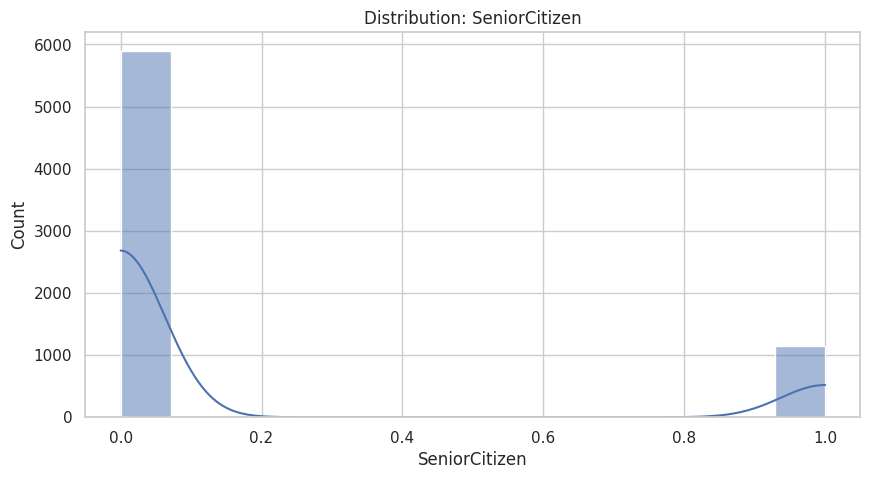

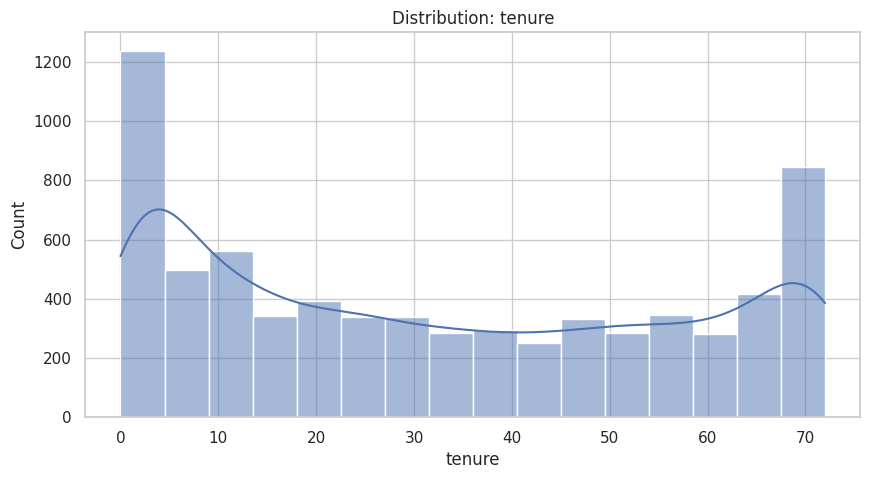

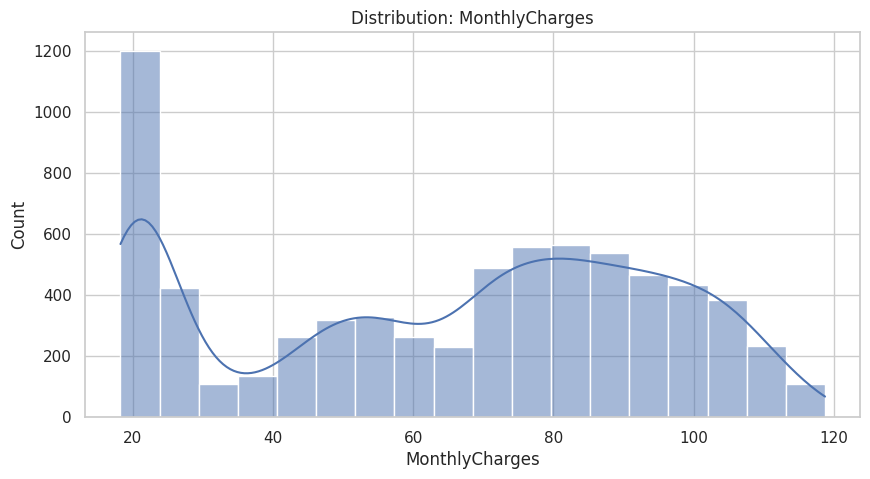

In [42]:
# Cell 4: histogram + KDE for numeric features (exclude TARGET if numeric)
num_plot_cols = [c for c in num_cols if c != TARGET]
for col in num_plot_cols:
    plt.figure()
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col)
    plt.show()


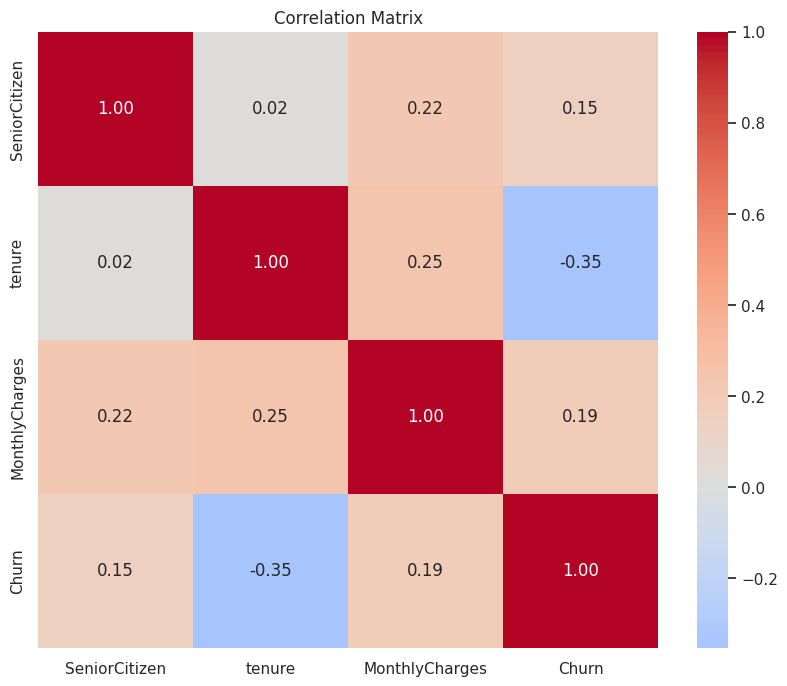

In [43]:
# Cell 5: correlation heatmap for numeric features (including TARGET if numeric)
corr_cols = [c for c in num_cols if c in df.columns]
if TARGET is not None and TARGET in df.columns and TARGET not in corr_cols and pd.api.types.is_numeric_dtype(df[TARGET]):
    corr_cols.append(TARGET)

if len(corr_cols) >= 2:
    corr = df[corr_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.show()
else:
    print("Not enough numeric columns for a correlation matrix.")


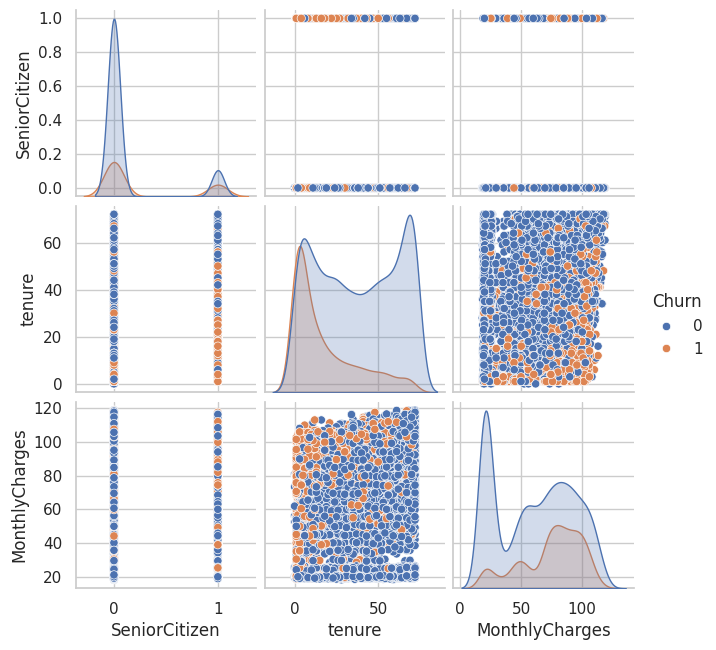

In [44]:
# Cell 10: small pairplot for up to 4 numeric features + target (comment out if slow)
pair_cols = corr_cols[:4]
if TARGET is not None and TARGET not in pair_cols and TARGET in df.columns:
    pair_cols = pair_cols + [TARGET]
if len(pair_cols) > 1:
    try:
        sns.pairplot(df[pair_cols].dropna(), hue=TARGET if TARGET in pair_cols else None, diag_kind='kde', height=2.2)
    except Exception as e:
        print("Pairplot skipped/failed (may be slow or memory-heavy):", e)


In [47]:
# Cell 1: define X, y and train/test split (no SMOTE)
TARGET = "Churn"   # change if your target column has a different name

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)
print("Class distribution (train):")
print(y_train.value_counts())


Train shape: (5634, 19)
Test shape : (1409, 19)
Class distribution (train):
Churn
0    4139
1    1495
Name: count, dtype: int64


In [ ]:
# Cell 2: evaluation helper (works for models with predict_proba)
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, confusion_matrix)
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    # try to get probability for positive class
    y_prob = None
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        try:
            y_prob = model.decision_function(X_test)
        except Exception:
            y_prob = None

    print(f"--- {name} ---")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
    print("F1 Score :", f1_score(y_test, y_pred, zero_division=0))
    if y_prob is not None:
        try:
            print("ROC-AUC  :", roc_auc_score(y_test, y_prob))
        except Exception as e:
            print("ROC-AUC error:", e)
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return y_prob, y_pred


In [49]:
# Cell 2: evaluation helper (works for models with predict_proba)
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, confusion_matrix)
import numpy as np

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    # try to get probability for positive class
    y_prob = None
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        try:
            y_prob = model.decision_function(X_test)
        except Exception:
            y_prob = None

    print(f"--- {name} ---")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
    print("F1 Score :", f1_score(y_test, y_pred, zero_division=0))
    if y_prob is not None:
        try:
            print("ROC-AUC  :", roc_auc_score(y_test, y_prob))
        except Exception as e:
            print("ROC-AUC error:", e)
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return y_prob, y_pred


In [50]:

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)

y_prob_lr, y_pred_lr = evaluate_model(lr, X_test, y_test, name="Logistic Regression")


--- Logistic Regression ---
Accuracy : 0.8005677785663591
Precision: 0.6555183946488294
Recall   : 0.5240641711229946
F1 Score : 0.5824665676077266
ROC-AUC  : 0.8409646335477537

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409

Confusion Matrix:
 [[932 103]
 [178 196]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [51]:
# Cell 4: Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_prob_rf, y_pred_rf = evaluate_model(rf, X_test, y_test, name="Random Forest")


--- Random Forest ---
Accuracy : 0.7856635911994322
Precision: 0.6276595744680851
Recall   : 0.4732620320855615
F1 Score : 0.5396341463414634
ROC-AUC  : 0.8178692293781809

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.47      0.54       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.77      0.79      0.78      1409

Confusion Matrix:
 [[930 105]
 [197 177]]


In [52]:
# Cell 5: install XGBoost (run only if not installed)
!pip install xgboost -q


In [53]:
# Cell 6: XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)

y_prob_xgb, y_pred_xgb = evaluate_model(xgb, X_test, y_test, name="XGBoost")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:44:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost ---
Accuracy : 0.7984386089425124
Precision: 0.6490066225165563
Recall   : 0.5240641711229946
F1 Score : 0.5798816568047337
ROC-AUC  : 0.8386860936733059

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

Confusion Matrix:
 [[929 106]
 [178 196]]


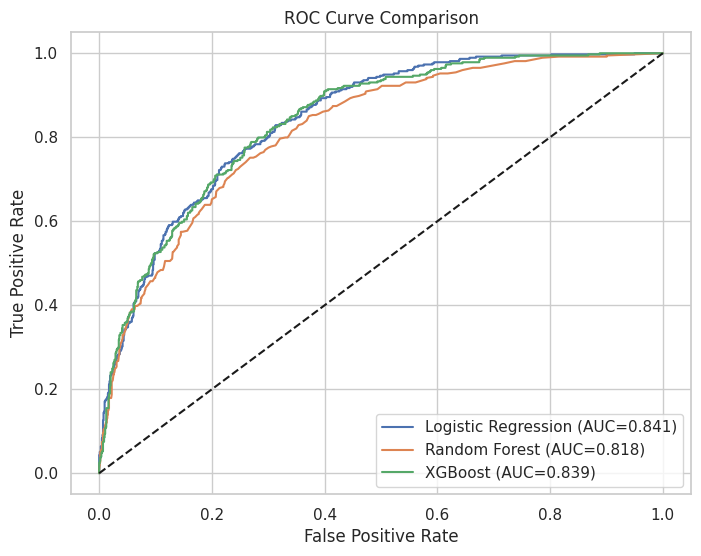

In [54]:
# Cell 7: ROC curves for all models
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)

models_probs = [
    ("Logistic Regression", y_prob_lr),
    ("Random Forest", y_prob_rf),
    ("XGBoost", y_prob_xgb)
]

plt.figure()
for name, probs in models_probs:
    if probs is None:
        continue
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


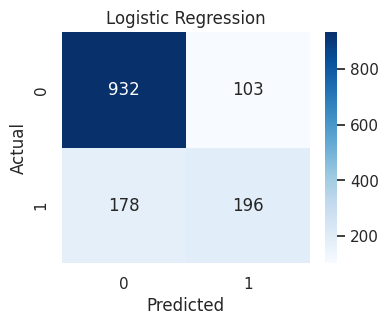

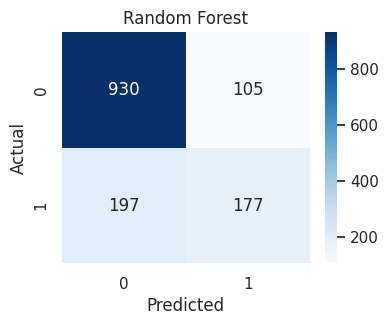

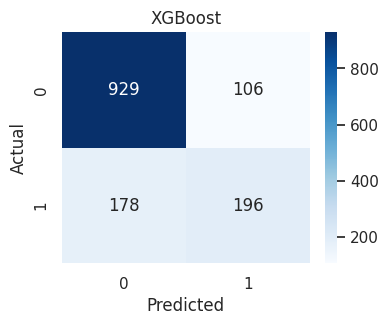

In [55]:
# Cell 8: visual confusion matrices
import seaborn as sns
plt.rcParams['figure.figsize'] = (4,3)

def plot_cm(y_true, y_pred, title):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title(title)
    plt.show()

plot_cm(y_test, y_pred_lr, "Logistic Regression")
plot_cm(y_test, y_pred_rf, "Random Forest")
plot_cm(y_test, y_pred_xgb, "XGBoost")


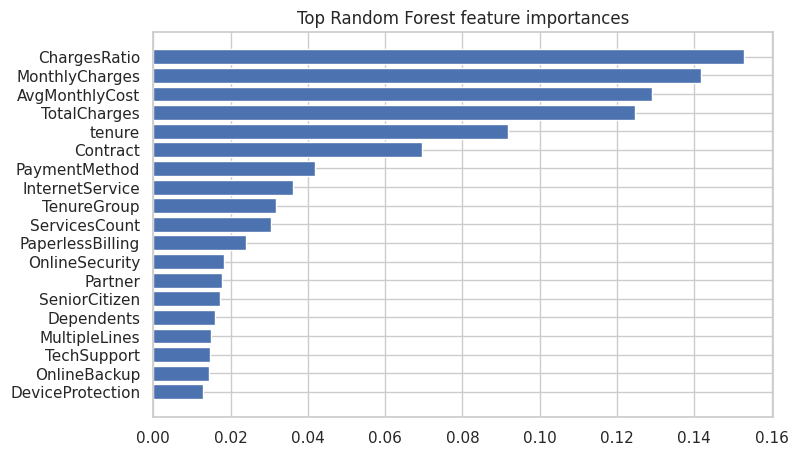

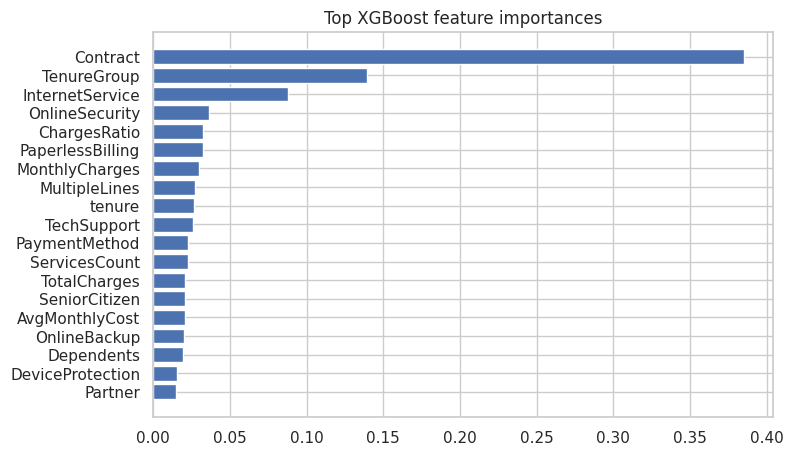

In [56]:
# Cell 9: feature importances (uses X.columns as feature names)
feature_names = list(X.columns)

# Random Forest importances
try:
    importances_rf = rf.feature_importances_
    idx = importances_rf.argsort()[::-1][:20]  # top 20
    plt.figure(figsize=(8,5))
    plt.barh([feature_names[i] for i in idx[::-1]], importances_rf[idx[::-1]])
    plt.title("Top Random Forest feature importances")
    plt.show()
except Exception as e:
    print("RF importances error:", e)

# XGBoost importances
try:
    importances_xgb = xgb.feature_importances_
    idx2 = importances_xgb.argsort()[::-1][:20]
    plt.figure(figsize=(8,5))
    plt.barh([feature_names[i] for i in idx2[::-1]], importances_xgb[idx2[::-1]])
    plt.title("Top XGBoost feature importances")
    plt.show()
except Exception as e:
    print("XGB importances error:", e)


In [59]:
# Save models directly to Google Drive
import pickle

save_path = "/content/drive/MyDrive/"   # create folder in Drive first

with open(save_path + "logistic_model.pkl", "wb") as f:
    pickle.dump(lr, f)

with open(save_path + "random_forest_model.pkl", "wb") as f:
    pickle.dump(rf, f)

with open(save_path + "xgboost_model.pkl", "wb") as f:
    pickle.dump(xgb, f)

print("Saved to:", save_path)


Saved to: /content/drive/MyDrive/


In [61]:
# 1) Install deps
!pip install -q streamlit pyngrok pandas scikit-learn xgboost

In [62]:
%%bash
cat > app.py << 'PY'
import streamlit as st
import pandas as pd
import pickle
import os
from pathlib import Path

SAVE_PATH = "/content/drive/MyDrive/"

st.set_page_config(page_title="Churn Model Dashboard", layout="wide")

st.title("Churn Prediction Dashboard")

# Helper to load model safely
def load_model(fname):
    path = Path(SAVE_PATH) / fname
    if path.exists():
        with open(path, "rb") as f:
            return pickle.load(f)
    return None

# Load models (if present)
models = {}
models['Logistic Regression'] = load_model("logistic_model.pkl")
models['Random Forest'] = load_model("random_forest_model.pkl")
models['XGBoost'] = load_model("xgboost_model.pkl")

# Load optional preprocessor/encoder
encoder = load_model("encoder.pkl")  # may be None

st.sidebar.header("Model & Input")
model_choice = st.sidebar.selectbox("Pick model", [k for k,v in models.items() if v is not None] or ["No models found"])

st.sidebar.markdown("---")
st.sidebar.write("Upload a CSV with the same feature columns used at training.")
uploaded_file = st.file_uploader("Upload CSV", type=["csv"])

if uploaded_file is None:
    st.info("Upload a CSV file with your features (one row per sample).")
else:
    try:
        df = pd.read_csv(uploaded_file)
    except Exception as e:
        st.error(f"Failed to read CSV: {e}")
        st.stop()

    st.write("Input preview (first 5 rows):")
    st.dataframe(df.head())

    # Transform if encoder available
    if encoder is not None:
        try:
            # If encoder is a sklearn ColumnTransformer/pipeline, use transform
            X = encoder.transform(df)
            # If transform returns numpy array, convert to DataFrame with feature names if possible
            try:
                cols = encoder.get_feature_names_out()
            except Exception:
                cols = [f"f{i}" for i in range(X.shape[1])]
            X = pd.DataFrame(X, columns=cols)
            st.write("Applied saved encoder/preprocessor.")
        except Exception as e:
            st.warning(f"Encoder present but failed to transform input automatically: {e}. Assuming uploaded CSV is already preprocessed.")
            X = df.copy()
    else:
        X = df.copy()

    # Predict
    model = models.get(model_choice)
    if model is None:
        st.error("Selected model not available on Drive.")
    else:
        try:
            if hasattr(model, "predict_proba"):
                probs = model.predict_proba(X)[:,1]
                preds = model.predict(X)
                df_out = df.copy()
                df_out["prediction"] = preds
                df_out["probability"] = probs
            else:
                preds = model.predict(X)
                df_out = df.copy()
                df_out["prediction"] = preds
                df_out["probability"] = None

            st.write("Predictions (first 10 rows):")
            st.dataframe(df_out.head(10))

            # Offer download
            csv = df_out.to_csv(index=False).encode('utf-8')
            st.download_button(label="Download predictions CSV", data=csv, file_name="predictions_with_model.csv", mime='text/csv')
        except Exception as e:
            st.error(f"Prediction failed: {e}")
PY